In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'histtype': 'stepfilled', 'alpha': 0.5, 'density': True}

In [5]:
# Check Versions
print(tf.__version__)  # 1.15.0
print(keras.__version__)  # 2.2.4

1.15.0
2.2.4


# OmniFold Gaussian Toy Example

We will unfold the same data but with two cases:

(a) there are no generator MC weights from using simulation.

(b) there are generator MC weights from using simulation.

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

In [7]:
N = 10**6
# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (1, 1.5)  # this is the data (the target)
epsilon = sigma0 / 1.  # Smearing width

theta0_G = np.random.normal(theta0_param[0], theta0_param[1],
                            N)  # Generator-level synthetic sample

# Toy MC weights from "MC sampling"
weightsMC_0 = np.array([(np.random.normal(abs(x), epsilon)) for x in theta0_G
                        ])  # Detector smearing for synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G
                     ])  # Detector smearing for synthetic sample
theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

theta_unknown_G = np.random.normal(theta_unknown_param[0],
                                   theta_unknown_param[1], N)
# Toy MC weights from "MC sampling"
weightsMC_unknown = np.array([(np.random.normal(abs(x), epsilon))
                              for x in theta_unknown_G])
# Detector smearing for synthetic sample
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon))
                            for x in theta_unknown_G])
theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

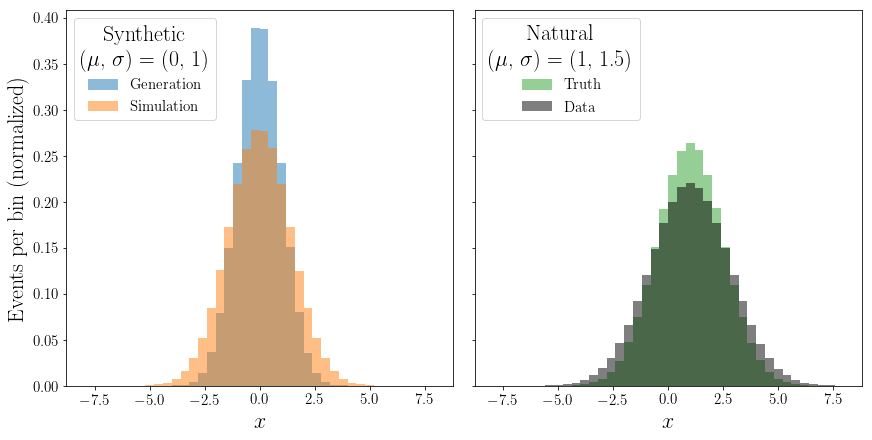

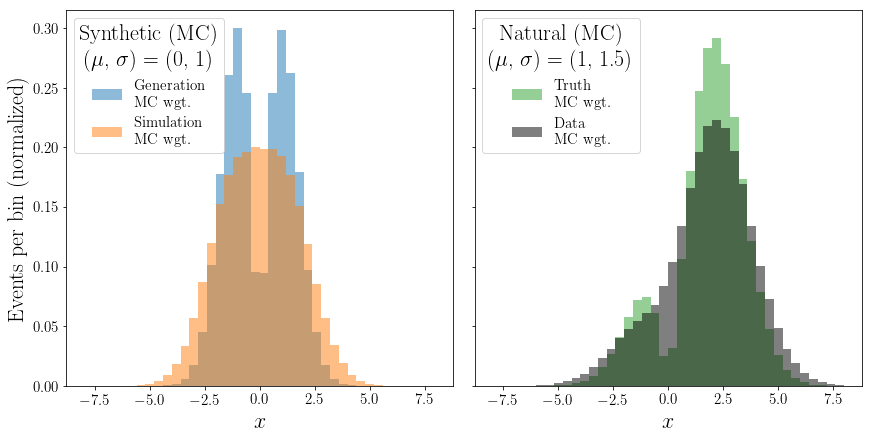

In [8]:
bins = np.linspace(-8, 8, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G, bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S, bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G,
           bins=bins,
           **plot_style_2,
           color='C2',
           label='Truth')
ax[1].hist(theta_unknown_S, bins=bins, **plot_style_2, color='k', label='Data')
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')
# fig.savefig(
#     'SupportNote/figures/GaussianToyExample/GaussianToyExample-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

bins = np.linspace(-8, 8, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G,
           weights=weightsMC_0,
           bins=bins,
           **plot_style_2,
           label='Generation\nMC wgt.')
ax[0].hist(theta0_S,
           weights=weightsMC_0,
           bins=bins,
           **plot_style_2,
           label='Simulation\nMC wgt.')
legend = ax[0].legend(
    title='Synthetic (MC)\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G,
           weights=weightsMC_unknown,
           bins=bins,
           **plot_style_2,
           color='C2',
           label='Truth\nMC wgt.')
ax[1].hist(theta_unknown_S,
           weights=weightsMC_unknown,
           bins=bins,
           **plot_style_2,
           color='k',
           label='Data\nMC wgt.')
legend = ax[1].legend(
    title='Natural (MC)\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')
# fig.savefig(
#     'SupportNote/figures/GaussianToyExample/GaussianToyExample-MCDistributions.pdf',
#     bbox_inches='tight')
fig.show()

## Unfold Data

In [9]:
iterations = 10

In [10]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((theta0_G, theta0_G))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [11]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(weights)

### Unfold without initial MC weights

In [12]:
# initial iterative weights are ones

weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [13]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              sample_weight=w_train_1,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1, Y_test_1, w_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push = reweight(theta0_G)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1500000 samples, validate on 500000 samples
Epoch 1/200





1500000/1500000 [==============================] - 11s 7us/step - loss: 0.6412 - acc: 0.6242 - val_loss: 0.6361 - val_acc: 0.6314
Epoch 2/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6358 - val_acc: 0.6316
Epoch 3/200
1500000/1500000 [==============================] - 9s 6us/step - loss: 0.6363 - acc: 0.6305 - val_loss: 0.6359 - val_acc: 0.6314
Epoch 4/200
1500000/1500000 [==============================] - 10s 6us/step - loss: 0.6362 - acc: 0.6306 - val_loss: 0.6359 - val_acc: 0.6316
Epoch 5/200
1500000/1500000 [==============================] - 10s 6us/step - loss: 0.6362 - acc: 0.6306 - val_loss: 0.6359 - val_acc: 0.6311
Epoch 6/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.6362 - acc: 0.6306 - val_

1500000/1500000 [==============================] - 13s 8us/step - loss: 0.6611 - acc: 0.5003 - val_loss: 0.6604 - val_acc: 0.4993
Epoch 12/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6611 - acc: 0.5002 - val_loss: 0.6602 - val_acc: 0.4991
Restoring model weights from the end of the best epoch
Epoch 00012: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 14s 9us/step - loss: 0.6724 - acc: 0.6215 - val_loss: 0.6701 - val_acc: 0.6222
Epoch 2/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6710 - acc: 0.6232 - val_loss: 0.6699 - val_acc: 0.6231
Epoch 3/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.6710 - acc: 0.6228 - val_loss: 0.6705 - val_acc: 0.6188
Epoch 4/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.6710 - acc: 0.6227 - val_loss: 0.6699 - val_acc: 0.6223


1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6916 - acc: 0.5913 - val_loss: 0.6899 - val_acc: 0.5934
Epoch 21/200
1500000/1500000 [==============================] - 11s 7us/step - loss: 0.6917 - acc: 0.5898 - val_loss: 0.6899 - val_acc: 0.5846
Epoch 22/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.6916 - acc: 0.5892 - val_loss: 0.6900 - val_acc: 0.5888
Epoch 23/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6916 - acc: 0.5885 - val_loss: 0.6899 - val_acc: 0.5914
Epoch 24/200
1500000/1500000 [==============================] - 11s 7us/step - loss: 0.6916 - acc: 0.5905 - val_loss: 0.6899 - val_acc: 0.5863
Restoring model weights from the end of the best epoch
Epoch 00024: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 15s 10us/step - loss: 0.6198 - acc: 0.5002 - val_loss: 0.6121 - val_acc: 0.4996
Epoch 2/20

1500000/1500000 [==============================] - 13s 9us/step - loss: 0.6942 - acc: 0.5438 - val_loss: 0.6972 - val_acc: 0.5631
Epoch 7/200
1500000/1500000 [==============================] - 14s 10us/step - loss: 0.6942 - acc: 0.5443 - val_loss: 0.6969 - val_acc: 0.5578
Epoch 8/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6943 - acc: 0.5373 - val_loss: 0.6970 - val_acc: 0.6202
Epoch 9/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6943 - acc: 0.5527 - val_loss: 0.6970 - val_acc: 0.5824
Epoch 10/200
1500000/1500000 [==============================] - 14s 9us/step - loss: 0.6942 - acc: 0.5444 - val_loss: 0.6966 - val_acc: 0.5825
Epoch 11/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6942 - acc: 0.5420 - val_loss: 0.6978 - val_acc: 0.5541
Epoch 12/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6943 - acc: 0.5465 - val_loss: 0.6975 - val_acc: 0.5326
Epoch 13/200
1

1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6947 - acc: 0.5160 - val_loss: 0.7031 - val_acc: 0.4780
Epoch 14/200
1500000/1500000 [==============================] - 15s 10us/step - loss: 0.6949 - acc: 0.5302 - val_loss: 0.7040 - val_acc: 0.5053
Epoch 15/200
1500000/1500000 [==============================] - 14s 9us/step - loss: 0.6948 - acc: 0.5165 - val_loss: 0.7032 - val_acc: 0.5267
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.6040 - acc: 0.4999 - val_loss: 0.5903 - val_acc: 0.4997
Epoch 2/200
1500000/1500000 [==============================] - 14s 9us/step - loss: 0.5894 - acc: 0.5000 - val_loss: 0.5903 - val_acc: 0.4997
Epoch 3/200
1500000/1500000 [==============================] - 15s 10us/step - loss: 0.5894 - acc: 0.5001 - val_loss: 0.5902 - val_acc: 0.4997
Epoch 4/200

1500000/1500000 [==============================] - 13s 9us/step - loss: 0.7010 - acc: 0.4336 - val_loss: 0.6948 - val_acc: 0.4814
Epoch 10/200
1500000/1500000 [==============================] - 13s 8us/step - loss: 0.7012 - acc: 0.4597 - val_loss: 0.6941 - val_acc: 0.4768
Epoch 11/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.7011 - acc: 0.4344 - val_loss: 0.6941 - val_acc: 0.5026
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 17s 11us/step - loss: 0.6013 - acc: 0.5002 - val_loss: 0.5912 - val_acc: 0.4992
Epoch 2/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5914 - acc: 0.5003 - val_loss: 0.5911 - val_acc: 0.4992
Epoch 3/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5914 - acc: 0.5002 - val_loss: 0.5911 - val_acc: 0.4993
Epoch 4/200


1500000/1500000 [==============================] - 15s 10us/step - loss: 0.6876 - acc: 0.4839 - val_loss: 0.6889 - val_acc: 0.4186
Epoch 5/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.6877 - acc: 0.4695 - val_loss: 0.6896 - val_acc: 0.4065
Epoch 6/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6877 - acc: 0.4782 - val_loss: 0.6890 - val_acc: 0.6249
Epoch 7/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.6876 - acc: 0.4905 - val_loss: 0.6892 - val_acc: 0.4093
Epoch 8/200
1500000/1500000 [==============================] - 15s 10us/step - loss: 0.6878 - acc: 0.4884 - val_loss: 0.6896 - val_acc: 0.4373
Epoch 9/200
1500000/1500000 [==============================] - 14s 9us/step - loss: 0.6877 - acc: 0.4801 - val_loss: 0.6892 - val_acc: 0.5067
Epoch 10/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6878 - acc: 0.4735 - val_loss: 0.6890 - val_acc: 0.4836
Epoch 11/200
15

1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5933 - acc: 0.5000 - val_loss: 0.5933 - val_acc: 0.4999
Epoch 24/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5933 - acc: 0.5000 - val_loss: 0.5930 - val_acc: 0.4999
Epoch 25/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5933 - acc: 0.5001 - val_loss: 0.5931 - val_acc: 0.4999
Epoch 26/200
1500000/1500000 [==============================] - 15s 10us/step - loss: 0.5933 - acc: 0.5001 - val_loss: 0.5931 - val_acc: 0.4999
Epoch 27/200
1500000/1500000 [==============================] - 15s 10us/step - loss: 0.5933 - acc: 0.5000 - val_loss: 0.5930 - val_acc: 0.4999
Epoch 28/200
1500000/1500000 [==============================] - 14s 9us/step - loss: 0.5933 - acc: 0.5001 - val_loss: 0.5932 - val_acc: 0.4999
Epoch 29/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5933 - acc: 0.5000 - val_loss: 0.5930 - val_acc: 0.4999
Epoch 30/2

#### Results

ITERATION 1:


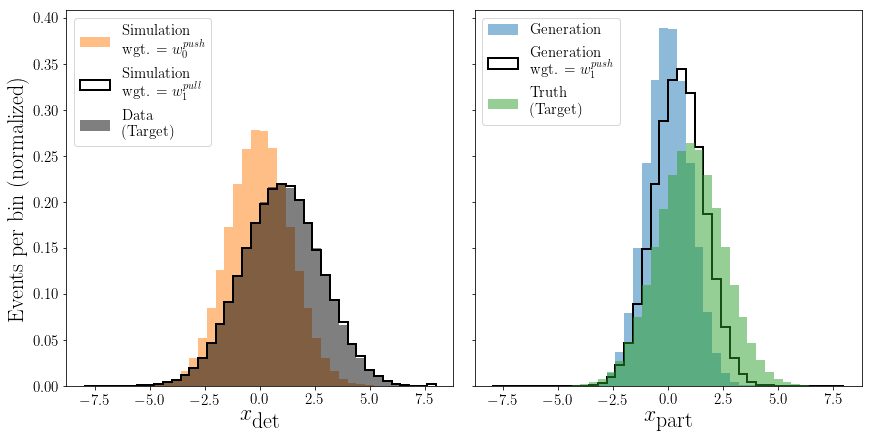

ITERATION 2:


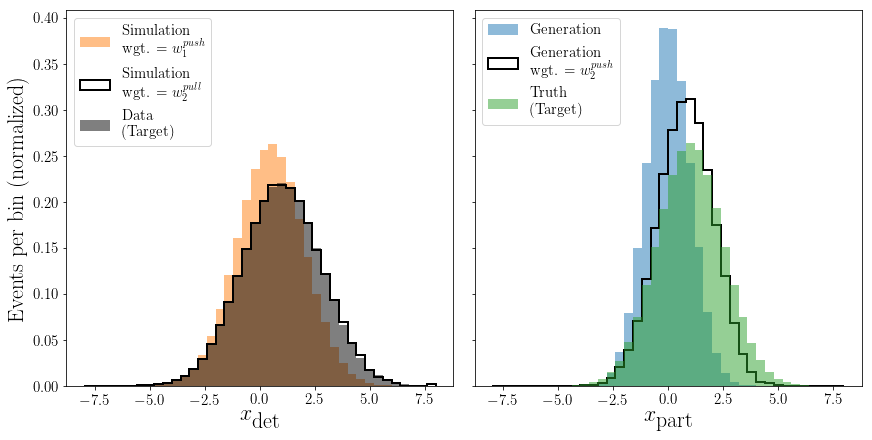

ITERATION 3:


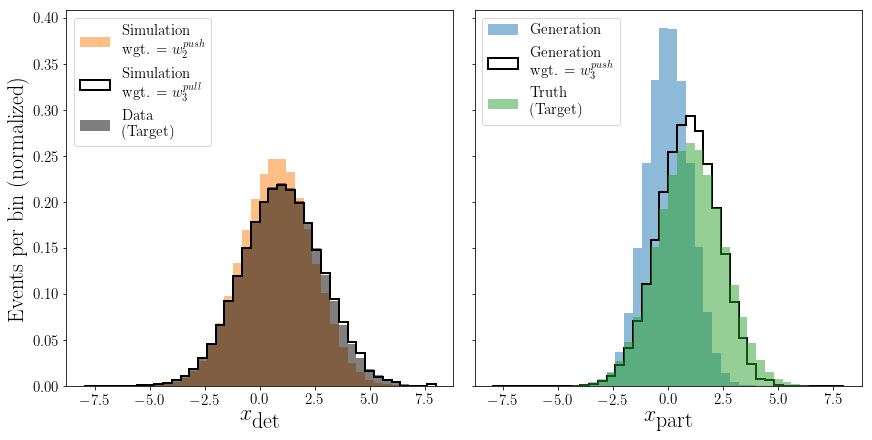

ITERATION 4:


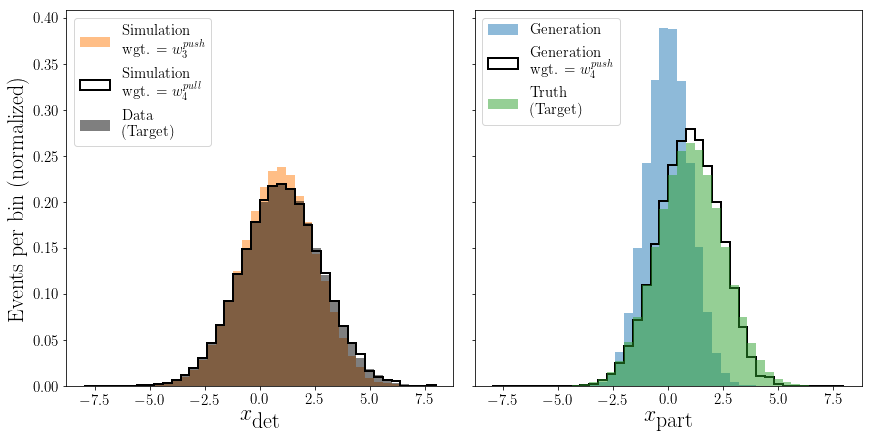

ITERATION 5:


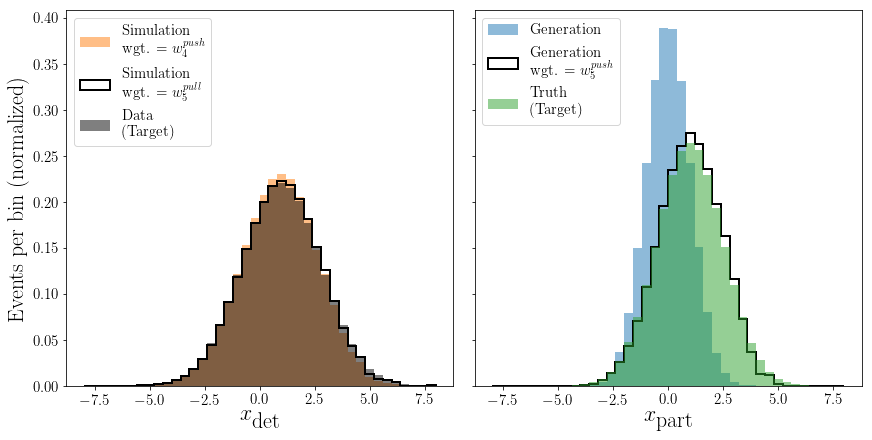

ITERATION 6:


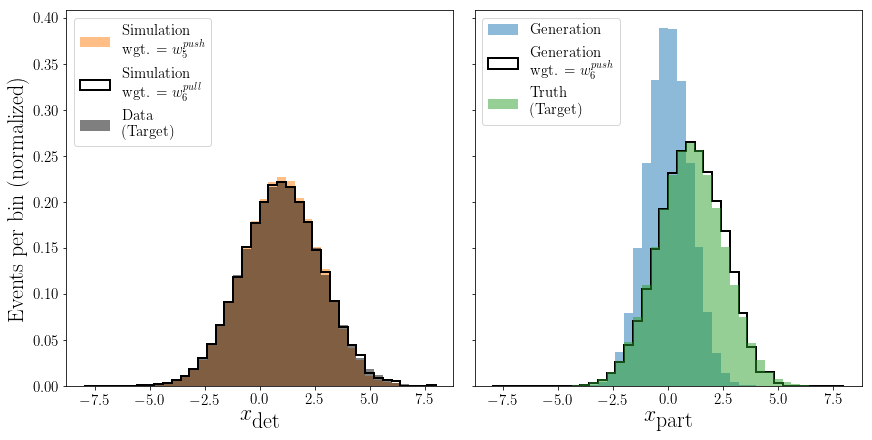

ITERATION 7:


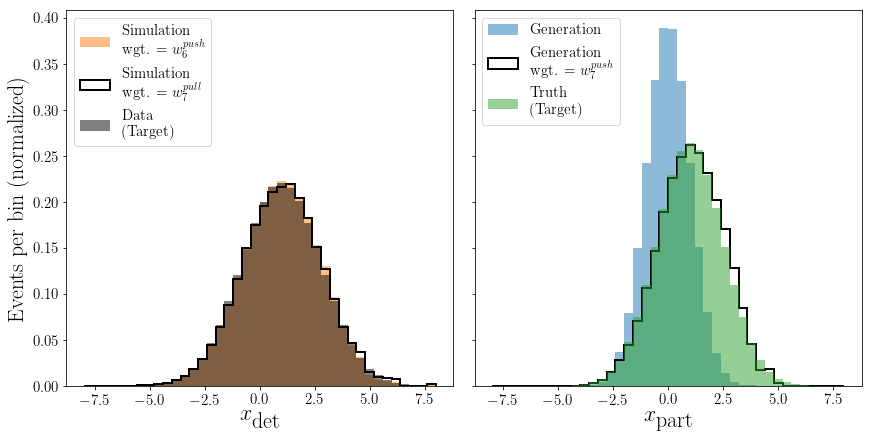

ITERATION 8:


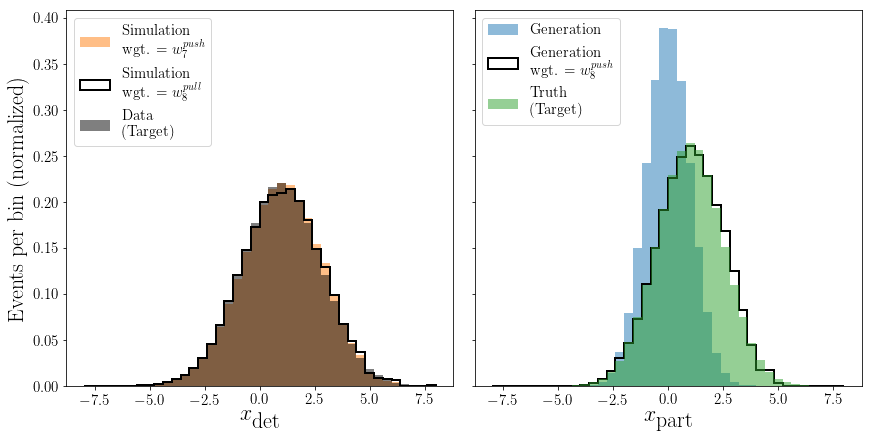

ITERATION 9:


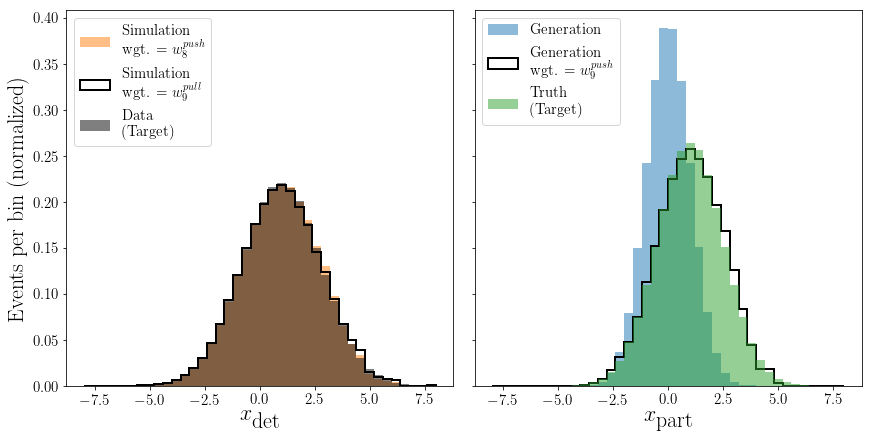

ITERATION 10:


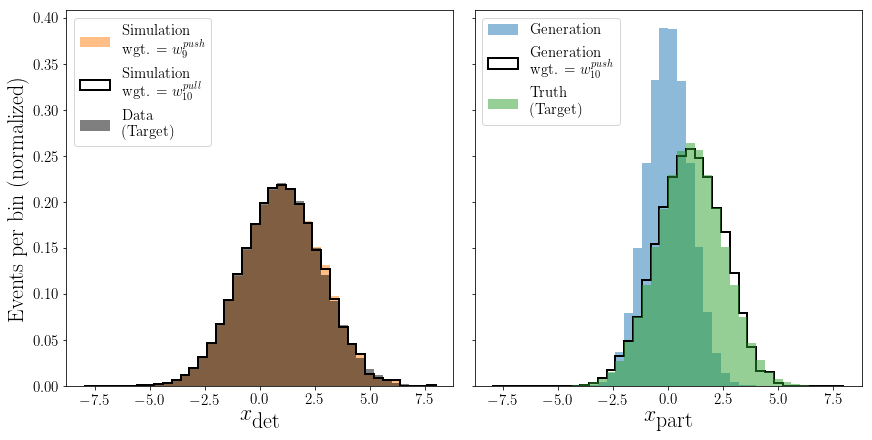

In [14]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(theta0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    ax[0].hist(theta0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) +
                                                                 '}'),
               **plot_style_2,
               color='C1')

    ax[0].hist(
        theta0_S,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 0, :],
        **plot_style_1)
    ax[0].hist(theta_unknown_S,
               bins=bins,
               label='Data\n(Target)',
               **plot_style_2,
               color='k')
    ax[0].set_xlabel(r"$x_{\textnormal{det}}$")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend(loc='upper left')
    ax[1].hist(theta0_G, bins=bins, label=r'Generation', **plot_style_2)

    ax[1].hist(
        theta0_G,
        bins=bins,
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 1, :],
        **plot_style_1)
    ax[1].hist(theta_unknown_G,
               bins=bins,
               label='Truth\n(Target)',
               **plot_style_2,
               color='C2')
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel(r"$x_{\textnormal{part}}$")

    fig.show()
#     fig.savefig(
#         'SupportNote/figures/GaussianToyExample/GaussianToyExample-UnfoldingResultsIteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

### Unfold with initial MC weights

In [15]:
# increase number of iterations
iterations = 10

In [16]:
# initial iterative weights are MC weights

weights_pull = weightsMC_0
weights_push = weightsMC_0

In [17]:
# clear total weights

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

In [18]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, weightsMC_unknown))
    # actual weights for Sim., initial MC weights for Data

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              sample_weight=w_train_1,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1, Y_test_1, w_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((weightsMC_0, weights_pull))
    # initial MC weights for Gen., actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    # note we need to take into account MC weights when reweighting the synthetic gen.
    weights_push = weightsMC_0 * reweight(theta0_G)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 15s 10us/step - loss: 0.6195 - acc: 0.6189 - val_loss: 0.6167 - val_acc: 0.6169
Epoch 2/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6163 - acc: 0.6164 - val_loss: 0.6167 - val_acc: 0.6157
Epoch 3/200
1500000/1500000 [==============================] - 14s 9us/step - loss: 0.6163 - acc: 0.6167 - val_loss: 0.6168 - val_acc: 0.6157
Epoch 4/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.6163 - acc: 0.6167 - val_loss: 0.6168 - val_acc: 0.6172
Epoch 5/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.6164 - acc: 0.6166 - val_loss: 0.6170 - val_acc: 0.6161
Epoch 6/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.6163 - acc: 0.6170 - val_loss: 0.6168 - val_acc: 0.6155
Epoch 7/200
1500000/1500000 [==============================] - 10s 7us/

Epoch 15/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.6008 - acc: 0.5000 - val_loss: 0.6011 - val_acc: 0.5001
Epoch 16/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.6008 - acc: 0.5000 - val_loss: 0.6011 - val_acc: 0.5001
Epoch 17/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.6008 - acc: 0.5001 - val_loss: 0.6011 - val_acc: 0.5001
Epoch 18/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.6008 - acc: 0.5000 - val_loss: 0.6010 - val_acc: 0.5001
Epoch 19/200
1500000/1500000 [==============================] - 10s 6us/step - loss: 0.6008 - acc: 0.4999 - val_loss: 0.6010 - val_acc: 0.5001
Epoch 20/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.6008 - acc: 0.5001 - val_loss: 0.6010 - val_acc: 0.4999
Restoring model weights from the end of the best epoch
Epoch 00020: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate o

1500000/1500000 [==============================] - 10s 7us/step - loss: 0.9922 - acc: 0.5394 - val_loss: 1.0117 - val_acc: 0.5412
Epoch 11/200
1500000/1500000 [==============================] - 11s 7us/step - loss: 0.9924 - acc: 0.5359 - val_loss: 1.0112 - val_acc: 0.5322
Epoch 12/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.9927 - acc: 0.5374 - val_loss: 1.0096 - val_acc: 0.5254
Epoch 13/200
1500000/1500000 [==============================] - 11s 7us/step - loss: 0.9925 - acc: 0.5435 - val_loss: 1.0118 - val_acc: 0.5483
Epoch 14/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.9923 - acc: 0.5383 - val_loss: 1.0106 - val_acc: 0.5409
Epoch 15/200
1500000/1500000 [==============================] - 11s 7us/step - loss: 0.9923 - acc: 0.5407 - val_loss: 1.0116 - val_acc: 0.5533
Epoch 16/200
1500000/1500000 [==============================] - 11s 7us/step - loss: 0.9931 - acc: 0.5354 - val_loss: 1.0106 - val_acc: 0.5497
Epoch 17/200


ITERATION: 6

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 13s 8us/step - loss: 1.0906 - acc: 0.5549 - val_loss: 1.0062 - val_acc: 0.5343
Epoch 2/200
1500000/1500000 [==============================] - 10s 6us/step - loss: 1.0230 - acc: 0.5446 - val_loss: 1.0129 - val_acc: 0.5008
Epoch 3/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 1.0223 - acc: 0.5451 - val_loss: 1.0058 - val_acc: 0.5230
Epoch 4/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 1.0217 - acc: 0.5327 - val_loss: 1.0056 - val_acc: 0.5540
Epoch 5/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 1.0221 - acc: 0.5409 - val_loss: 1.0075 - val_acc: 0.5116
Epoch 6/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 1.0228 - acc: 0.5389 - val_loss: 1.0050 - val_acc: 0.5495
Epoch 7/200
1500000/1500000 [==============================] - 10s 6us/s

Epoch 22/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 1.0523 - acc: 0.4688 - val_loss: 1.0261 - val_acc: 0.5059
Epoch 23/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 1.0512 - acc: 0.4980 - val_loss: 1.0286 - val_acc: 0.5043
Epoch 24/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 1.0514 - acc: 0.4735 - val_loss: 1.0256 - val_acc: 0.4438
Restoring model weights from the end of the best epoch
Epoch 00024: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5979 - acc: 0.5006 - val_loss: 0.5577 - val_acc: 0.4990
Epoch 2/200
1500000/1500000 [==============================] - 9s 6us/step - loss: 0.5592 - acc: 0.5004 - val_loss: 0.5577 - val_acc: 0.4989
Epoch 3/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.5592 - acc: 0.5005 - val_loss: 0.5575 - val_acc: 0.4989
E

1500000/1500000 [==============================] - 10s 7us/step - loss: 1.0148 - acc: 0.5434 - val_loss: 1.0249 - val_acc: 0.5002
Epoch 12/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 1.0149 - acc: 0.4934 - val_loss: 1.0171 - val_acc: 0.5257
Epoch 13/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 1.0142 - acc: 0.5265 - val_loss: 1.0166 - val_acc: 0.5325
Epoch 14/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 1.0140 - acc: 0.5113 - val_loss: 1.0170 - val_acc: 0.5580
Epoch 15/200
1500000/1500000 [==============================] - 10s 6us/step - loss: 1.0146 - acc: 0.5189 - val_loss: 1.0182 - val_acc: 0.4999
Epoch 16/200
1500000/1500000 [==============================] - 9s 6us/step - loss: 1.0145 - acc: 0.5291 - val_loss: 1.0187 - val_acc: 0.5003
Epoch 17/200
1500000/1500000 [==============================] - 10s 6us/step - loss: 1.0135 - acc: 0.5426 - val_loss: 1.0209 - val_acc: 0.5003
Epoch 18/200


1500000/1500000 [==============================] - 11s 7us/step - loss: 0.5577 - acc: 0.4999 - val_loss: 0.5596 - val_acc: 0.5004
Epoch 7/200
1500000/1500000 [==============================] - 9s 6us/step - loss: 0.5576 - acc: 0.5000 - val_loss: 0.5595 - val_acc: 0.5003
Epoch 8/200
1500000/1500000 [==============================] - 10s 6us/step - loss: 0.5577 - acc: 0.4999 - val_loss: 0.5595 - val_acc: 0.5003
Epoch 9/200
1500000/1500000 [==============================] - 10s 6us/step - loss: 0.5576 - acc: 0.4999 - val_loss: 0.5594 - val_acc: 0.5001
Epoch 10/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.5577 - acc: 0.4999 - val_loss: 0.5597 - val_acc: 0.5003
Epoch 11/200
1500000/1500000 [==============================] - 9s 6us/step - loss: 0.5577 - acc: 0.4999 - val_loss: 0.5595 - val_acc: 0.5001
Epoch 12/200
1500000/1500000 [==============================] - 10s 7us/step - loss: 0.5576 - acc: 0.5000 - val_loss: 0.5596 - val_acc: 0.5002
Epoch 13/200
1500

#### Results

ITERATION 1:


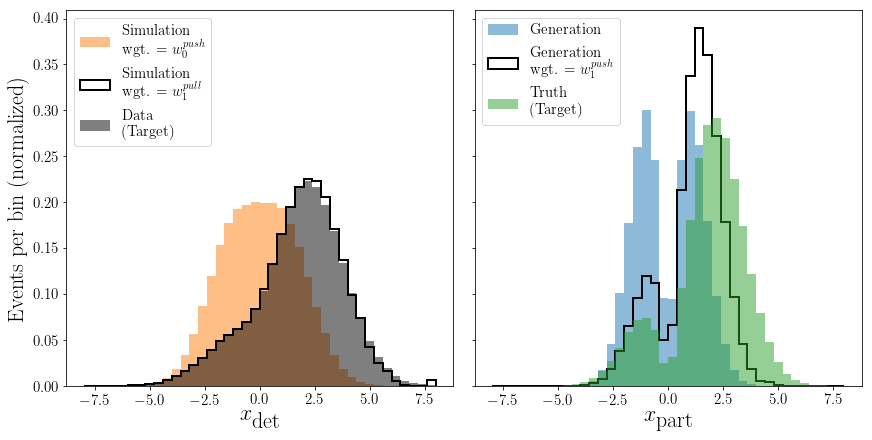

ITERATION 2:


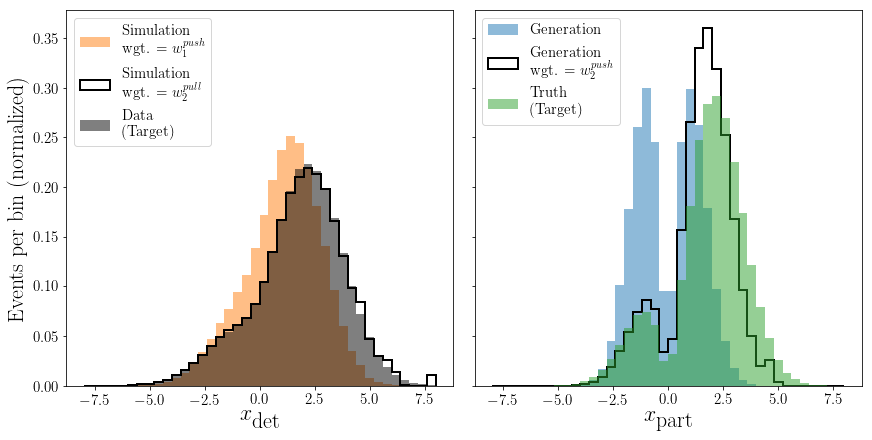

ITERATION 3:


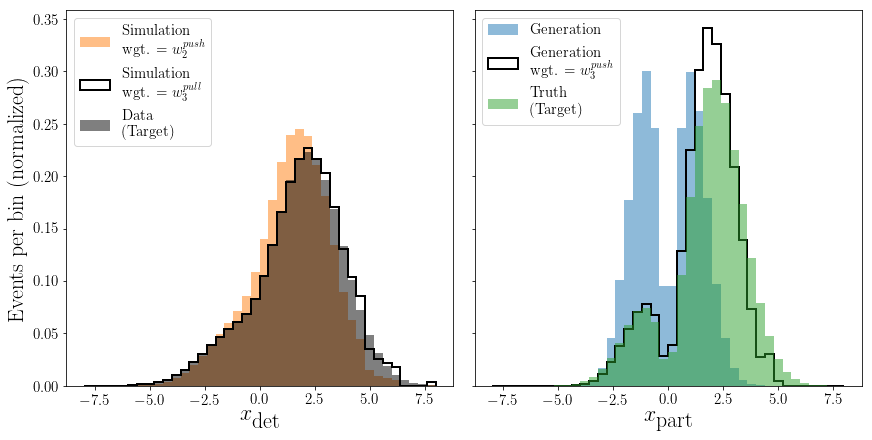

ITERATION 4:


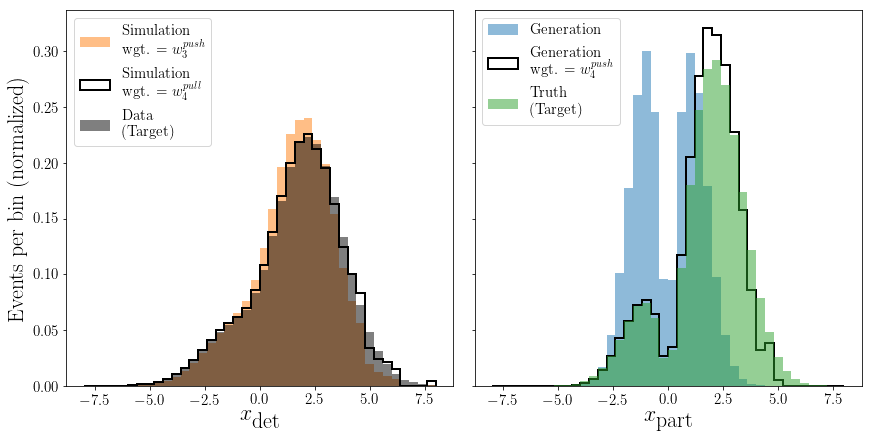

ITERATION 5:


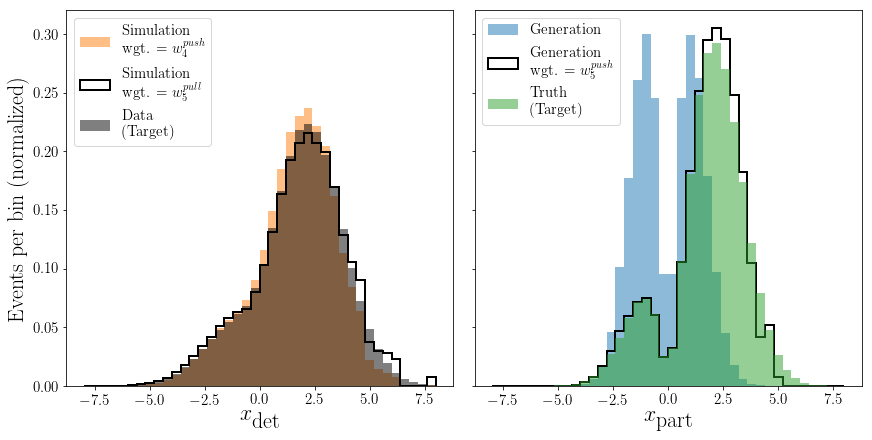

ITERATION 6:


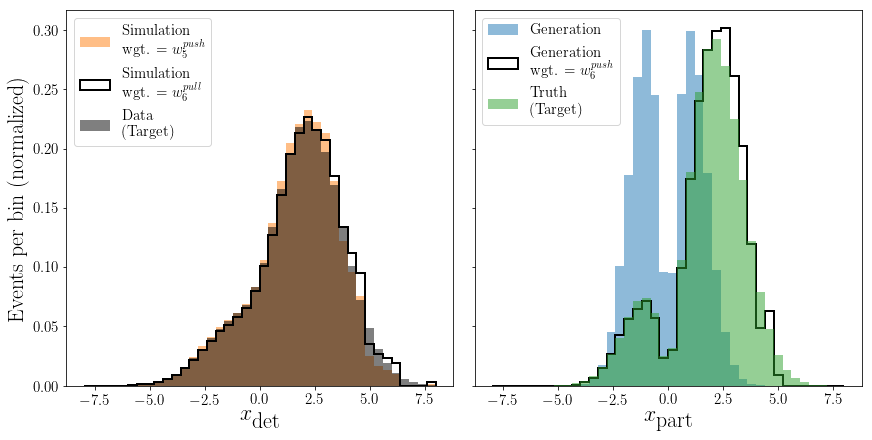

ITERATION 7:


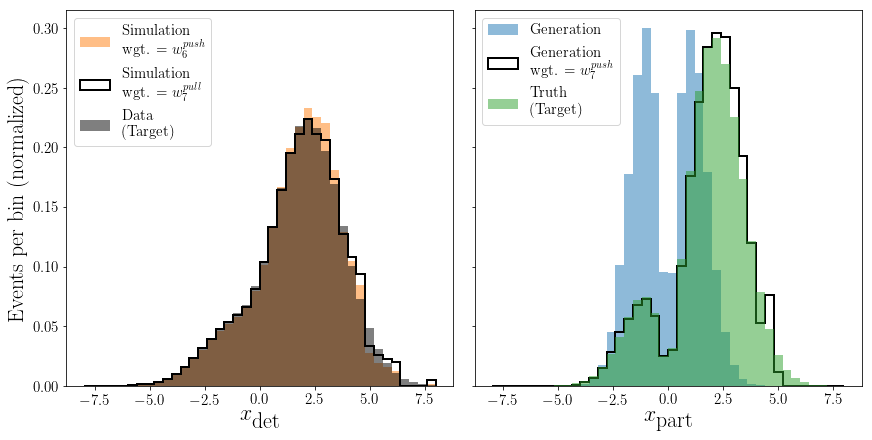

ITERATION 8:


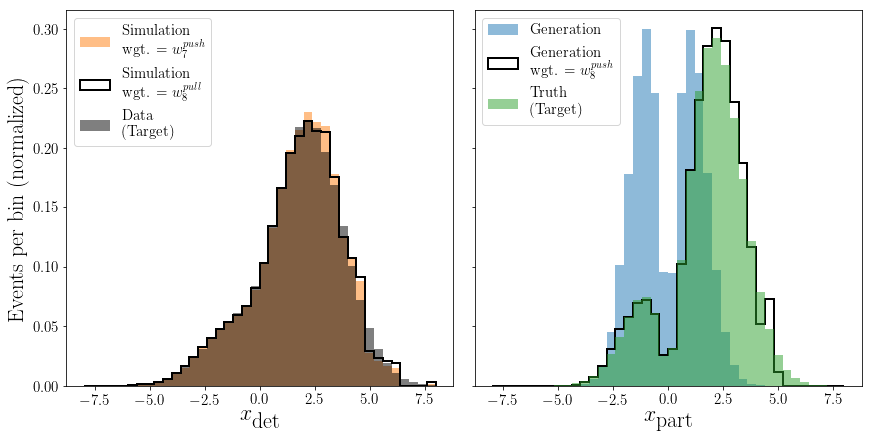

ITERATION 9:


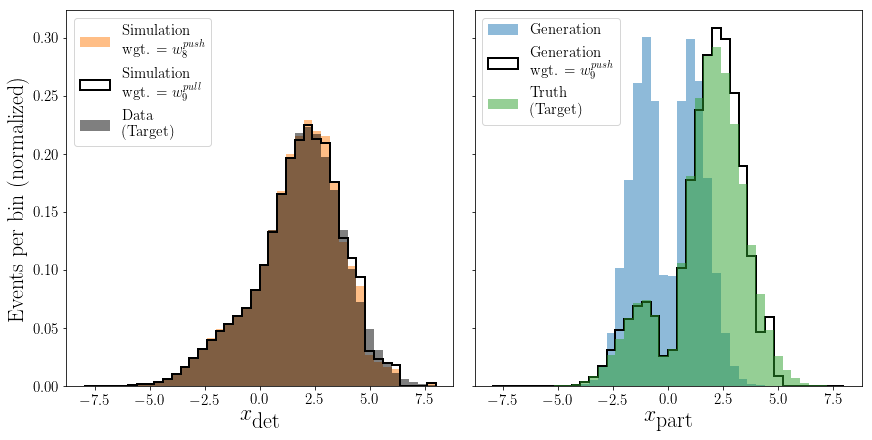

ITERATION 10:


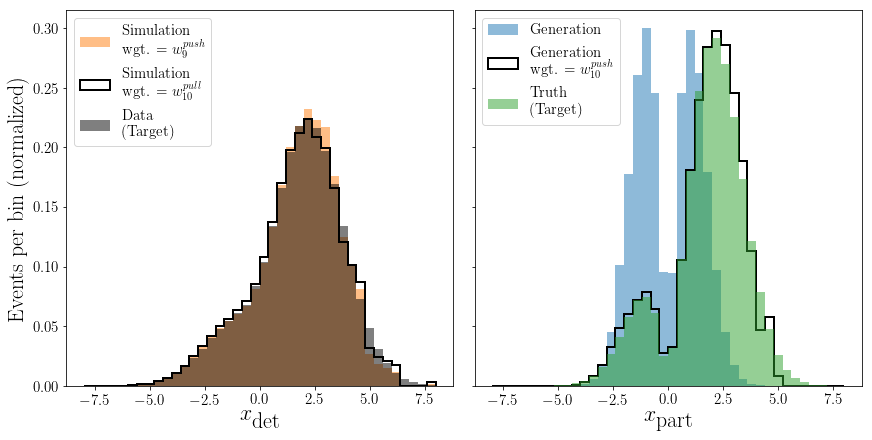

In [19]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = weightsMC_0
    else:
        weights_init = weights[i - 1, 1, :]

    ax[0].hist(theta0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) +
                                                                 '}'),
               **plot_style_2,
               color='C1')

    ax[0].hist(
        theta0_S,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 0, :],
        **plot_style_1)
    ax[0].hist(theta_unknown_S,
               weights=weightsMC_unknown,
               bins=bins,
               label='Data\n(Target)',
               **plot_style_2,
               color='k')
    ax[0].set_xlabel(r"$x_{\textnormal{det}}$")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend(loc='upper left')
    ax[1].hist(theta0_G,
               weights=weightsMC_0,
               bins=bins,
               label=r'Generation',
               **plot_style_2)

    ax[1].hist(
        theta0_G,
        bins=bins,
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 1, :],
        **plot_style_1)
    ax[1].hist(theta_unknown_G,
               weights=weightsMC_unknown,
               bins=bins,
               label='Truth\n(Target)',
               **plot_style_2,
               color='C2')
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel(r"$x_{\textnormal{part}}$")

    fig.show()
#     fig.savefig(
#         'SupportNote/figures/GaussianToyExample/GaussianToyExample-MCUnfoldingResultsIteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()